In [1]:
!uv add numpy matplotlib scipy

Resolved 105 packages in 6ms
Audited 102 packages in 18ms



===== АНАЛИТИЧЕСКИЕ РЕЗУЛЬТАТЫ (регрессия lnA) =====
λ = 0.010406 ± 0.000024  1/ч
T1/2 (analytic) = 66.612 ± 0.151 ч  (2.775 сут)
A0 (analytic) = 150.216 ± 0.001 имп/с
N0 = 1.444e+04 ± 3.280e+01 ядер
Средняя относительная статистическая погрешность по измерениям ≈ 1.08%
Коэффициент корреляции R² = 0.999824

t (ч)	Счёт	A (имп/с)	ln(A)
   1	 15897	  148.97	   5.004
   2	 15678	  146.78	   4.989
   3	 15580	  145.80	   4.982
   4	 15393	  143.93	   4.969
   5	 15223	  142.23	   4.957
   6	 15146	  141.46	   4.952
   7	 14938	  139.38	   4.937
   8	 14882	  138.82	   4.933
   9	 14691	  136.91	   4.919
  10	 14398	  133.98	   4.898
  12	 14308	  133.08	   4.891
  14	 14046	  130.46	   4.871
  16	 13670	  126.70	   4.842
  18	 13415	  124.15	   4.821
  20	 13187	  121.87	   4.803
  22	 12890	  118.90	   4.778
  24	 12614	  116.14	   4.755
  26	 12463	  114.63	   4.742
  28	 12215	  112.15	   4.720
  30	 11996	  109.96	   4.700
  35	 11414	  104.14	   4.646
  40	 11048	  100.48	   4.610
  4

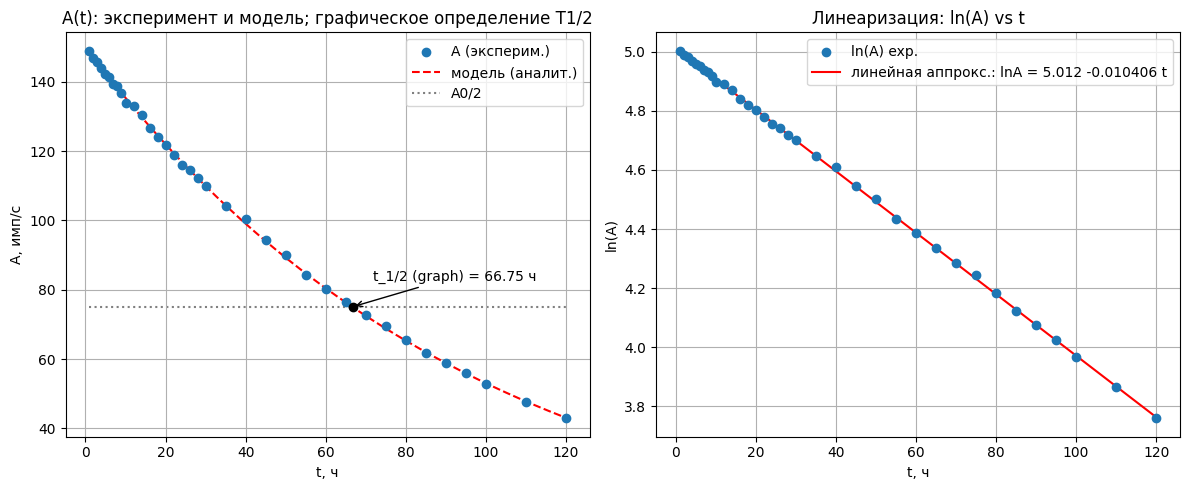

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- Исходные данные ---
time = np.array([1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,22,24,26,
                 28,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120])
count = np.array([15897,15678,15580,15393,15223,15146,14938,14882,14691,14398,
                  14308,14046,13670,13415,13187,12890,12614,12463,
                  12215,11996,11414,11048,10433,10012,9440,9034,8641,8269,
                  7964,7553,7179,6881,6587,6287,5767,5292])

# --- Константы ---
t_meas = 100.0         # время набора информации (с)
background_rate = 10.0 # фон (имп/с)
background_counts = background_rate * t_meas  # фон за время измерения, имп.

# --- Расчёт активности и lnA ---
A = (count - background_counts) / t_meas      # активность (имп/с)
lnA = np.log(A)

# --- АНАЛИТИЧЕСКАЯ часть: линейная аппроксимация lnA = lnA0 - λ t ---
slope, intercept, r_value, p_value, std_err = linregress(time, lnA)
lambda_ = -slope
T_half_analytic = np.log(2) / lambda_
A0_analytic = np.exp(intercept)

# оценка погрешностей (см. пояснения)
n = len(time)
mean_t = np.mean(time)
Sxx = np.sum((time - mean_t)**2)
stderr_slope = std_err
stderr_intercept = std_err * np.sqrt(np.sum(time**2)/(n * Sxx))

sigma_lambda = stderr_slope
sigma_T = (np.log(2) / lambda_**2) * sigma_lambda
sigma_A0 = A0_analytic * stderr_intercept

# --- Число ядер ---
N0 = A0_analytic / lambda_
sigma_N0 = N0 * np.sqrt((sigma_A0/A0_analytic)**2 + (sigma_lambda/lambda_)**2)

# --- СТАТИСТИЧЕСКАЯ погрешность измерений ---
sigma_N = np.sqrt(count)
sigma_A = sigma_N / t_meas
rel_error = sigma_A / A
mean_rel_error = np.mean(rel_error) * 100

# --- ГРАФИЧЕСКИЙ способ: найти t, при котором A(t) = A0/2 ---
# для интерполяции используем монотонный массив времени и активности (A убывает)
# если нужно, можно сначала сделать более плотную интерполяцию экспоненциальной модели
from scipy.interpolate import interp1d

# создадим интерполятор A(t)
interp_A = interp1d(time, A, kind='linear', bounds_error=False, fill_value='extrapolate')

# целевая активность = A0/2 (возьмём аналитическое A0 для ориентира)
A_half = A0_analytic / 2.0

# найдем численно t_graphical: решим A(t)=A_half, сделаем точную интерполяцию на мелкой сетке
t_fine = np.linspace(time.min(), time.max(), 5000)
A_fine = interp_A(t_fine)

# найти индекс ближайшего значения к A_half
idx = np.argmin(np.abs(A_fine - A_half))
t_half_graphical = t_fine[idx]
A_at_t_half = A_fine[idx]

# --- Вывод результатов ---
print("\n===== АНАЛИТИЧЕСКИЕ РЕЗУЛЬТАТЫ (регрессия lnA) =====")
print(f"λ = {lambda_:.6f} ± {sigma_lambda:.6f}  1/ч")
print(f"T1/2 (analytic) = {T_half_analytic:.3f} ± {sigma_T:.3f} ч  ({T_half_analytic/24:.3f} сут)")
print(f"A0 (analytic) = {A0_analytic:.3f} ± {sigma_A0:.3f} имп/с")
print(f"N0 = {N0:.3e} ± {sigma_N0:.3e} ядер")
print(f"Средняя относительная статистическая погрешность по измерениям ≈ {mean_rel_error:.2f}%")
print(f"Коэффициент корреляции R² = {r_value**2:.6f}\n")

# --- Таблица расчётов ---
print("t (ч)\tСчёт\tA (имп/с)\tln(A)")
for i in range(0, len(time)):
    print(f"{time[i]:>4}\t{count[i]:>6}\t{A[i]:>8.2f}\t{lnA[i]:>8.3f}")

print("\n===== ГРАФИЧЕСКИЙ РЕЗУЛЬТАТ (по A(t)) =====")
print(f"A0/2 = {A_half:.3f} имп/с")
print(f"T1/2 (graphical, interpolation) = {t_half_graphical:.3f} ч")
print(f"A(t_half)_interpolated = {A_at_t_half:.3f} имп/с (≈ A0/2)")

# разница между методами
diff = T_half_analytic - t_half_graphical
print(f"\nРазница T1/2(analytic) - T1/2(graphical) = {diff:.3f} ч ({100*diff/T_half_analytic:.3f} %)")

# --- графики и аннотации ---
plt.figure(figsize=(12,5))

# 1) A(t) и отметка A0/2
plt.subplot(1,2,1)
plt.scatter(time, A, label='A (эксперим.)', zorder=3)
t_plot = np.linspace(time.min(), time.max(), 200)
plt.plot(t_plot, A0_analytic * np.exp(-lambda_ * t_plot), 'r--', label='модель (аналит.)', zorder=2)
plt.hlines(A_half, time.min(), time.max(), colors='gray', linestyles=':', label='A0/2', zorder=1)
plt.scatter([t_half_graphical], [A_at_t_half], color='black', zorder=5)
plt.annotate(f"t_1/2 (graph) = {t_half_graphical:.2f} ч",
             xy=(t_half_graphical, A_at_t_half),
             xytext=(t_half_graphical+5, A_at_t_half*1.1),
             arrowprops=dict(arrowstyle="->"))
plt.xlabel("t, ч")
plt.ylabel("A, имп/с")
plt.title("A(t): эксперимент и модель; графическое определение T1/2")
plt.legend()
plt.grid(True)

# 2) ln(A) и линейная аппроксимация
plt.subplot(1,2,2)
plt.scatter(time, lnA, label='ln(A) exp.', zorder=3)
plt.plot(t_plot, intercept + slope * t_plot, 'r', label=f"линейная аппрокс.: lnA = {intercept:.3f} {slope:+.6f} t", zorder=2)
plt.xlabel("t, ч")
plt.ylabel("ln(A)")
plt.title("Линеаризация: ln(A) vs t")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Полученный период полураспада ~2.78 сут соответствует радионуклиду Au-198.

# Определён период полураспада и начальная активность и количество.

# Полученные данные хорошо описываются экспоненциальным законом (R²≈0.9998), средняя погрешность измерений ~1 %.